## Фреймворк PyTorch для разработки искусственных нейронных сетей

### Домашнее задание №6

**Урок 6. Нейросети в обработке текста**

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech  
Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

**Библиотеки**

In [2]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 89.4 MB/s eta 0:00:00
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=e89b705f6f813853148f3113a05037ed0a603eb09a4dd9d654dcdf6fdae8c5b7
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=431f5ecc3ba909808b86f7b9ae1df1682acec1788d251e29af4f06d02b047466
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built stop-words docopt


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("punkt")

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Подключение токена kaggle для загрузки датасета**

In [4]:
from google.colab import files

In [5]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Загрузка и распаковка датасета**

In [6]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

100% 1.89M/1.89M [00:01<00:00, 2.03MB/s]
100% 1.89M/1.89M [00:01<00:00, 1.78MB/s]


In [7]:
!unzip twitter-sentiment-analysis-hatred-speech.zip

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


**Параметры обучения**

In [74]:
max_words = 5000
max_len = 30
num_classes = 1

epochs = 15
batch_size = 512
print_batch_n = 100

In [75]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [76]:
train_df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

Разобьем обучающий датасет на тренировочную и валидационную выборки

In [77]:
X_train, X_valid = train_test_split(train_df, test_size=0.25, random_state=42)
X_train.shape, X_valid.shape

((23971, 3), (7991, 3))

In [78]:
X_train.label.value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [79]:
X_valid.label.value_counts()

0    7432
1     559
Name: label, dtype: int64

Произведем предобработку датасета

In [80]:
sw = set(get_stop_words("en"))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

In [81]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [82]:
morpher = WordNetLemmatizer()
morpher.lemmatize('cats')

'cat'

In [83]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [84]:
from tqdm import tqdm 
tqdm.pandas()

X_train.tweet = X_train.tweet.progress_apply(preprocess_text)
X_valid.tweet = X_valid.tweet.progress_apply(preprocess_text)

100%|██████████| 7991/7991 [00:00<00:00, 22927.60it/s]


In [85]:
train_corpus = " ".join(X_train.tweet)
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)
tokens[:6]

['weekend', 'world', 'really', 'going', 'bonkers', 'really']

Отфильтруем данные и соберём в корпус N наиболее частых токенов

In [86]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [87]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

4999

In [88]:
tokens_filtered_top[:6]

['user', 'love', 'day', 'u', 'happy', 'amp']

In [89]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'love': 2,
 'day': 3,
 'u': 4,
 'happy': 5,
 'amp': 6,
 'just': 7,
 'will': 8,
 'time': 9,
 'life': 10,
 'im': 11,
 'today': 12,
 'like': 13,
 'new': 14,
 'get': 15,
 'positive': 16,
 'now': 17,
 'thankful': 18,
 'father': 19,
 'good': 20,
 'make': 21,
 'people': 22,
 'bihday': 23,
 'one': 24,
 'cant': 25,
 'smile': 26,
 'see': 27,
 'go': 28,
 'can': 29,
 'dont': 30,
 'take': 31,
 'want': 32,
 'friend': 33,
 'work': 34,
 'weekend': 35,
 'healthy': 36,
 'girl': 37,
 'got': 38,
 'need': 39,
 'week': 40,
 'fun': 41,
 'summer': 42,
 'family': 43,
 'way': 44,
 'friday': 45,
 'great': 46,
 'best': 47,
 '2': 48,
 'beautiful': 49,
 'bull': 50,
 'going': 51,
 'know': 52,
 'year': 53,
 'wait': 54,
 'first': 55,
 'really': 56,
 'thing': 57,
 'back': 58,
 'world': 59,
 'music': 60,
 'morning': 61,
 'affirmation': 62,
 'home': 63,
 'come': 64,
 'look': 65,
 'dad': 66,
 'think': 67,
 'tomorrow': 68,
 'feel': 69,
 'cute': 70,
 'orlando': 71,
 'never': 72,
 'fathersday': 73,
 'sad': 74,
 

In [90]:
def text_to_sequence(text, maxlen):
    
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()] # проверка чтобы токен был либо буквенный либо символьный
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    
    return result[-maxlen:] + padding

In [91]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in X_valid.tweet])

x_train.shape, x_val.shape

CPU times: user 2.86 s, sys: 10.4 ms, total: 2.87 s
Wall time: 2.87 s


((23971, 30), (7991, 30))

In [92]:
train_df.tweet.iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [93]:
x_train[0]

array([35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Создадим архитектуру сети

In [95]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=64, out_channel=64, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

Создадим датасет и обернем его даталоадером

In [96]:
class Data_Twitter(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long() 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [97]:
train_dataset = Data_Twitter(x_train, X_train.label.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Data_Twitter(x_val, X_valid.label.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Проверим корректность созданного

In [98]:
train_loader.sampler

In [99]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 30])
torch.Size([512])
tensor(0)


In [100]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Выведем параметры модели, а также зададим оптимизатор и ошибку обучения

In [101]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(5000, 64)
  (conv_1): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)
Parameters: 342721


In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
criterion = nn.BCELoss()

**Начнем процесс обучения**

In [103]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения (переводим модель в валидацию)
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/15]. Step [47/47]. Loss: 0.204. Acc: 0.911. Test loss: 0.038. Test acc: 0.930
Epoch [2/15]. Step [47/47]. Loss: 0.166. Acc: 0.936. Test loss: 0.043. Test acc: 0.944
Epoch [3/15]. Step [47/47]. Loss: 0.087. Acc: 0.965. Test loss: 0.036. Test acc: 0.953
Epoch [4/15]. Step [47/47]. Loss: 0.070. Acc: 0.979. Test loss: 0.237. Test acc: 0.951
Epoch [5/15]. Step [47/47]. Loss: 0.051. Acc: 0.987. Test loss: 0.001. Test acc: 0.951
Epoch [6/15]. Step [47/47]. Loss: 0.008. Acc: 0.992. Test loss: 0.003. Test acc: 0.950
Epoch [7/15]. Step [47/47]. Loss: 0.019. Acc: 0.995. Test loss: 0.539. Test acc: 0.945
Epoch [8/15]. Step [47/47]. Loss: 0.004. Acc: 0.997. Test loss: 0.000. Test acc: 0.948
Epoch [9/15]. Step [47/47]. Loss: 0.005. Acc: 0.998. Test loss: 0.000. Test acc: 0.944
Epoch [10/15]. Step [47/47]. Loss: 0.030. Acc: 0.998. Test loss: 0.057. Test acc: 0.951
Epoch [11/15]. Step [47/47]. Loss: 0.001. Acc: 0.998. Test loss: 0.001. Test acc: 0.948
Epoch [12/15]. Step [47/47]. Loss: 0.002.

Визуализируем результаты

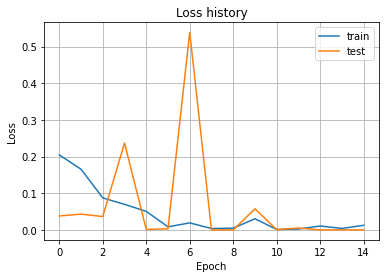

In [104]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

**Полученные выводы:**

*max_words = 1000  
max_len = 10*  

Epoch [1/15]. Step [47/47]. Loss: 0.215. Acc: 0.930. Test loss: 0.366. Test acc: 0.930  
Epoch [2/15]. Step [47/47]. Loss: 0.157. Acc: 0.932. Test loss: 0.125. Test acc: 0.938  
Epoch [3/15]. Step [47/47]. Loss: 0.150. Acc: 0.945. Test loss: 0.042. Test acc: 0.934  
Epoch [4/15]. Step [47/47]. Loss: 0.102. Acc: 0.955. Test loss: 0.142. Test acc: 0.944  
Epoch [5/15]. Step [47/47]. Loss: 0.088. Acc: 0.962. Test loss: 0.121. Test acc: 0.939  
Epoch [6/15]. Step [47/47]. Loss: 0.060. Acc: 0.970. Test loss: 1.310. Test acc: 0.935  
Epoch [7/15]. Step [47/47]. Loss: 0.063. Acc: 0.976. Test loss: 0.527. Test acc: 0.931  
Epoch [8/15]. Step [47/47]. Loss: 0.057. Acc: 0.982. Test loss: 0.074. Test acc: 0.931  
Epoch [9/15]. Step [47/47]. Loss: 0.048. Acc: 0.984. Test loss: 0.066. Test acc: 0.922  
Epoch [10/15]. Step [47/47]. Loss: 0.055. Acc: 0.981. Test loss: 1.686. Test acc: 0.922  
Epoch [11/15]. Step [47/47]. Loss: 0.028. Acc: 0.985. Test loss: 0.403. Test acc: 0.930  
Epoch [12/15]. Step [47/47]. Loss: 0.030. Acc: 0.988. Test loss: 0.000. Test acc: 0.931  
Epoch [13/15]. Step [47/47]. Loss: 0.022. Acc: 0.991. Test loss: 1.046. Test acc: 0.935  
Epoch [14/15]. Step [47/47]. Loss: 0.032. Acc: 0.992. Test loss: 0.803. Test acc: 0.938  
Epoch [15/15]. Step [47/47]. Loss: 0.019. Acc: 0.992. Test loss: 0.000. Test acc: 0.935  
Training is finished!

*max_words = 3000  
max_len = 10*  

Epoch [1/15]. Step [47/47]. Loss: 0.181. Acc: 0.912. Test loss: 0.027. Test acc: 0.932  
Epoch [2/15]. Step [47/47]. Loss: 0.164. Acc: 0.939. Test loss: 0.356. Test acc: 0.941  
Epoch [3/15]. Step [47/47]. Loss: 0.118. Acc: 0.958. Test loss: 0.701. Test acc: 0.947  
Epoch [4/15]. Step [47/47]. Loss: 0.070. Acc: 0.973. Test loss: 0.002. Test acc: 0.947  
Epoch [5/15]. Step [47/47]. Loss: 0.062. Acc: 0.982. Test loss: 0.416. Test acc: 0.944  
Epoch [6/15]. Step [47/47]. Loss: 0.046. Acc: 0.988. Test loss: 0.008. Test acc: 0.935  
Epoch [7/15]. Step [47/47]. Loss: 0.035. Acc: 0.989. Test loss: 0.040. Test acc: 0.941  
Epoch [8/15]. Step [47/47]. Loss: 0.018. Acc: 0.993. Test loss: 0.028. Test acc: 0.945  
Epoch [9/15]. Step [47/47]. Loss: 0.012. Acc: 0.996. Test loss: 0.084. Test acc: 0.941  
Epoch [10/15]. Step [47/47]. Loss: 0.013. Acc: 0.996. Test loss: 0.000. Test acc: 0.937  
Epoch [11/15]. Step [47/47]. Loss: 0.019. Acc: 0.996. Test loss: 1.224. Test acc: 0.945   
Epoch [12/15]. Step [47/47]. Loss: 0.036. Acc: 0.995. Test loss: 0.151. Test acc: 0.947  
Epoch [13/15]. Step [47/47]. Loss: 0.009. Acc: 0.995. Test loss: 0.004. Test acc: 0.940  
Epoch [14/15]. Step [47/47]. Loss: 0.023. Acc: 0.996. Test loss: 0.000. Test acc: 0.947  
Epoch [15/15]. Step [47/47]. Loss: 0.018. Acc: 0.997. Test loss: 2.399. Test acc: 0.942  
Training is finished!

*max_words = 5000  
max_len = 30*  

Epoch [1/15]. Step [47/47]. Loss: 0.204. Acc: 0.911. Test loss: 0.038. Test acc: 0.930  
Epoch [2/15]. Step [47/47]. Loss: 0.166. Acc: 0.936. Test loss: 0.043. Test acc: 0.944  
Epoch [3/15]. Step [47/47]. Loss: 0.087. Acc: 0.965. Test loss: 0.036. Test acc: 0.953  
Epoch [4/15]. Step [47/47]. Loss: 0.070. Acc: 0.979. Test loss: 0.237. Test acc: 0.951  
Epoch [5/15]. Step [47/47]. Loss: 0.051. Acc: 0.987. Test loss: 0.001. Test acc: 0.951  
Epoch [6/15]. Step [47/47]. Loss: 0.008. Acc: 0.992. Test loss: 0.003. Test acc: 0.950  
Epoch [7/15]. Step [47/47]. Loss: 0.019. Acc: 0.995. Test loss: 0.539. Test acc: 0.945  
Epoch [8/15]. Step [47/47]. Loss: 0.004. Acc: 0.997. Test loss: 0.000. Test acc: 0.948  
Epoch [9/15]. Step [47/47]. Loss: 0.005. Acc: 0.998. Test loss: 0.000. Test acc: 0.944  
Epoch [10/15]. Step [47/47]. Loss: 0.030. Acc: 0.998. Test loss: 0.057. Test acc: 0.951  
Epoch [11/15]. Step [47/47]. Loss: 0.001. Acc: 0.998. Test loss: 0.001. Test acc: 0.948  
Epoch [12/15]. Step [47/47]. Loss: 0.002. Acc: 0.999. Test loss: 0.005. Test acc: 0.943  
Epoch [13/15]. Step [47/47]. Loss: 0.011. Acc: 0.998. Test loss: 0.000. Test acc: 0.949  
Epoch [14/15]. Step [47/47]. Loss: 0.004. Acc: 0.997. Test loss: 0.000. Test acc: 0.944  
Epoch [15/15]. Step [47/47]. Loss: 0.013. Acc: 0.997. Test loss: 0.000. Test acc: 0.948  
Training is finished!

Таким образом мы можем сделать вывод о том, что увеличение словаря, а также длины при одинаковом количестве эпох.  
При этом мы можем наблюдать некоторые выбросы ошибки обучения на тестовой выборке, скорее всего обусловленные самим процессом обучения модели.
Тем не менее, мы можем сделать вывод о том, что увеличение количества и качества параметров обучения ведет к повышению качества результатов.  
Однако это одновременно вызывает значительный рост потребностей в вычислительных ресурсах(